#　説明変数の準備

In [1]:
from IPython.core.display import display
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook as tqdm

from sklearn import linear_model,preprocessing
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Yu Mincho'

#データの保存場所を指定
#この場合は、D:\DEV\workspace\stock_trade\linear_regressionを読み書きする。
WORK_DIR = 'D:\DEV\workspace\stock_trade\linear_regression'
DATA_DIR = 'D:\DEV\workspace\stock_trade\linear_regression\data'
DATA_CHAPTER1 = 'D:\DEV\workspace\stock_trade\data'

data = pd.read_pickle(f'{DATA_DIR}\excess_returns_with_financial_data.pickle')

In [2]:
#対数変換で正規分布に近づける
def correct_skewness(series):
    if series.min() <= 0:
        series += series.min() + 1
        
    corrected = np.log(series)
    
    return corrected
    
# 標準化して変数のスケールを合わせる
def standardize_characteristics(series):
    series = series.dropna()
    standardized = stats.zscore(series)
    
    return pd.Series(standardized, index = series.index)

# winsorizeによる外れ値の処理
def trim_outliers(series, limits = .01):
    series = series.dropna()
    trimmed = stats.mstats.winsorize(series, limits=limits)
    
    return pd.Series(trimmed, index = series.index)
                               

In [3]:
data

名称    市場     業種        日付      株価   前日比  前日比（％）    前日終値  \
SC   日時                                                                      
1301 2020-12-02    極洋  東証一部  水産・農林  20201202  2811.0  24.0    0.86  2787.0   
     2020-12-03    極洋  東証一部  水産・農林  20201203  2807.0  -4.0   -0.14  2811.0   
     2020-12-04    極洋  東証一部  水産・農林  20201204  2811.0   4.0    0.14  2807.0   
     2020-12-07    極洋  東証一部  水産・農林  20201207  2811.0   0.0    0.00  2811.0   
     2020-12-08    極洋  東証一部  水産・農林  20201208  2816.0   5.0    0.18  2811.0   
...               ...   ...    ...       ...     ...   ...     ...     ...   
9997 2021-12-24  ベルーナ  東証一部     小売  20211224   679.0   4.0    0.59   675.0   
     2021-12-27  ベルーナ  東証一部     小売  20211227   674.0  -5.0   -0.74   679.0   
     2021-12-28  ベルーナ  東証一部     小売  20211228   687.0  13.0    1.93   674.0   
     2021-12-29  ベルーナ  東証一部     小売  20211229   714.0  27.0    3.93   687.0   
     2021-12-30  ベルーナ  東証一部     小売  20211230   709.0  -5.0   -0.70   714.0   

                     始値      高値  ...  営業利益（百万円）  経常利益（百万円）  当期利益（百万円）  \
SC   日時                          ...                                    
1301 2020-12-02  2806.0  2817.0  ...     2918.0     3608.0     2037.0   
     2020-12-03  2810.0  2816.0  ...     2918.0     3608.0     2037.0   
     2020-12-04  2819.0  2819.0  ...     2918.0     3608.0     2037.0   
     2020-12-07  2820.0  2830.0  ...     2918.0     3608.0     2037.0   
     2020-12-08  2807.0  2824.0  ...     2918.0     3608.0     2037.0   
...                 ...     ...  ...        ...        ...        ...   
9997 2021-12-24   670.0   690.0  ...    15734.0    16872.0    11036.0   
     2021-12-27   680.0   680.0  ...    15734.0    16872.0    11036.0   
     2021-12-28   680.0   690.0  ...    15734.0    16872.0    11036.0   
     2021-12-29   691.0   714.0  ...    15734.0    16872.0    11036.0   
     2021-12-30   714.0   716.0  ...    15734.0    16872.0    11036.0   

                 総資産（百万円）  自己資本（百万円）  資本金（百万円）  有利子負債（百万円）  自己資本比率    ROE  \
SC   日時                                                                     
1301 2020-12-02  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-03  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-04  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-07  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
     2020-12-08  111184.0    32718.0    5664.0     54718.0    29.4   6.31   
...                   ...        ...       ...         ...     ...    ...   
9997 2021-12-24  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-27  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-28  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-29  240211.0   112620.0   10612.0     72706.0    46.9  10.29   
     2021-12-30  240211.0   112620.0   10612.0     72706.0    46.9  10.29   

                  ROA  
SC   日時                
1301 2020-12-02  1.80  
     2020-12-03  1.80  
     2020-12-04  1.80  
     2020-12-07  1.80  
     2020-12-08  1.80  
...               ...  
9997 2021-12-24  4.76  
     2021-12-27  4.76  
     2021-12-28  4.76  
     2021-12-29  4.76  
     2021-12-30  4.76  

[960897 rows x 49 columns]

In [4]:
data1 = data.astype(str)

In [5]:

group_by_date = data1.groupby('日時')

dataset_of_firm_size = []
dataset_of_firm_size1 = [] 
dataset_of_firm_size2 = [] 
dataset_of_firm_size3 = [] 
for date, value in group_by_date:
    market_value_of_equity = value['時価総額（百万円）'].astype(float)
    dataset_of_firm_size1.append(market_value_of_equity)
    market_value_of_equity = correct_skewness(
        market_value_of_equity
    )
    dataset_of_firm_size2.append(market_value_of_equity)
    market_value_of_equity = standardize_characteristics(
        market_value_of_equity
    )
    dataset_of_firm_size3.append(market_value_of_equity)
    market_value_of_equity = trim_outliers(
        market_value_of_equity
    )
    
    market_value_of_equity.name = '企業規模'
    
    dataset_of_firm_size.append(market_value_of_equity)
    
dataset_of_firm_size = pd.concat(dataset_of_firm_size)
    

In [6]:
dataset_of_firm_size1 = pd.concat(dataset_of_firm_size1)
dataset_of_firm_size2 = pd.concat(dataset_of_firm_size2)
dataset_of_firm_size3 = pd.concat(dataset_of_firm_size3)

(array([0.1098535 , 0.11922389, 0.21631065, 0.26536145, 0.34980325,
        0.36981598, 0.40698633, 0.45617245, 0.41430674, 0.39666199,
        0.40269693, 0.41681679, 0.35790171, 0.2934388 , 0.28575982,
        0.24291986, 0.20457228, 0.19167023, 0.15962822, 0.13648301,
        0.12734941, 0.09500294, 0.08570021, 0.08230386, 0.07521348,
        0.05243361, 0.03654116, 0.03617581, 0.0334222 , 0.0805448 ]),
 array([-1.7373231 , -1.5835023 , -1.4296815 , -1.2758607 , -1.1220399 ,
        -0.9682191 , -0.8143983 , -0.6605775 , -0.5067567 , -0.3529359 ,
        -0.19911509, -0.04529429,  0.10852651,  0.26234731,  0.41616811,
         0.56998891,  0.72380971,  0.87763051,  1.03145131,  1.18527211,
         1.33909291,  1.49291371,  1.64673451,  1.80055531,  1.95437611,
         2.10819691,  2.26201771,  2.41583851,  2.56965931,  2.72348011,
         2.87730091]),
 <BarContainer object of 30 artists>)

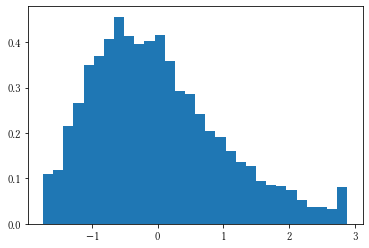

In [7]:
import matplotlib.pyplot as plt

plt.hist(dataset_of_firm_size, bins=30, density=True)

(array([8.28665247e-07, 1.35486980e-08, 6.62690569e-09, 2.98460963e-09,
        1.87029579e-09, 1.61830181e-09, 1.29124578e-09, 6.08538670e-10,
        1.90335884e-10, 2.49313200e-10, 2.06420606e-10, 1.84974309e-10,
        1.11699462e-10, 6.88068687e-11, 6.16581031e-11, 7.14876558e-11,
        8.93595697e-12, 2.41270838e-11, 2.14462967e-11, 3.57438279e-12,
        8.93595697e-12, 1.87655096e-11, 3.21694451e-11, 3.39566365e-11,
        1.07231484e-11, 5.36157418e-12, 1.07231484e-11, 6.25516988e-11,
        3.21694451e-11, 2.14462967e-11]),
 array([1.19000000e+02, 1.16473323e+06, 2.32934747e+06, 3.49396170e+06,
        4.65857593e+06, 5.82319017e+06, 6.98780440e+06, 8.15241863e+06,
        9.31703287e+06, 1.04816471e+07, 1.16462613e+07, 1.28108756e+07,
        1.39754898e+07, 1.51401040e+07, 1.63047183e+07, 1.74693325e+07,
        1.86339467e+07, 1.97985610e+07, 2.09631752e+07, 2.21277894e+07,
        2.32924037e+07, 2.44570179e+07, 2.56216321e+07, 2.67862464e+07,
        2.79508606e+07

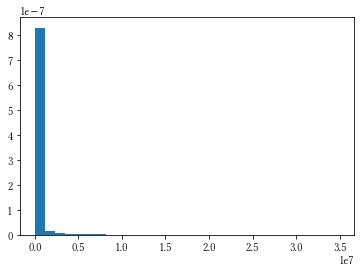

In [8]:
plt.hist(dataset_of_firm_size1, bins=30, density=True)

(array([2.47981598e-06, 2.23183438e-05, 7.43944794e-06, 1.25974652e-03,
        5.59446485e-03, 2.46444112e-02, 6.34039350e-02, 1.35891436e-01,
        1.94211748e-01, 2.17636090e-01, 2.54094345e-01, 2.28929172e-01,
        2.28110833e-01, 2.13685743e-01, 1.66452688e-01, 1.42616697e-01,
        1.15985953e-01, 9.04736063e-02, 7.51483435e-02, 5.68423419e-02,
        4.61196176e-02, 4.20254414e-02, 2.30300510e-02, 2.00319535e-02,
        1.53277426e-02, 1.04449849e-02, 7.24850211e-03, 2.19959678e-03,
        7.46424610e-04, 6.59631051e-04]),
 array([ 4.77912349,  5.19878942,  5.61845534,  6.03812127,  6.45778719,
         6.87745312,  7.29711904,  7.71678497,  8.13645089,  8.55611682,
         8.97578274,  9.39544867,  9.81511459, 10.23478052, 10.65444645,
        11.07411237, 11.4937783 , 11.91344422, 12.33311015, 12.75277607,
        13.172442  , 13.59210792, 14.01177385, 14.43143977, 14.8511057 ,
        15.27077162, 15.69043755, 16.11010347, 16.5297694 , 16.94943532,
        17.36910

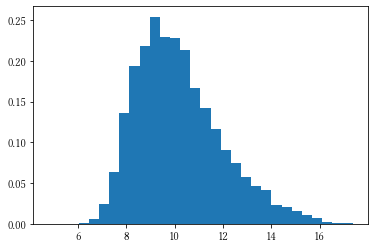

In [9]:
plt.hist(dataset_of_firm_size2, bins=30, density=True)

(array([4.37237475e-06, 3.93513727e-05, 1.31171242e-05, 1.77081177e-03,
        7.91399829e-03, 3.95699914e-02, 1.00722025e-01, 2.29763920e-01,
        3.32344204e-01, 3.82744568e-01, 4.44600554e-01, 4.12161905e-01,
        3.99250283e-01, 3.83697746e-01, 2.97986084e-01, 2.58778999e-01,
        2.05737721e-01, 1.64921603e-01, 1.34004541e-01, 1.02392272e-01,
        8.24848496e-02, 7.60749482e-02, 4.22808638e-02, 3.54730763e-02,
        2.76508979e-02, 1.89717340e-02, 1.32876469e-02, 4.15812838e-03,
        1.42976654e-03, 1.17179643e-03]),
 array([-3.09246506e+00, -2.85444926e+00, -2.61643346e+00, -2.37841766e+00,
        -2.14040186e+00, -1.90238606e+00, -1.66437026e+00, -1.42635447e+00,
        -1.18833867e+00, -9.50322868e-01, -7.12307069e-01, -4.74291270e-01,
        -2.36275471e-01,  1.74032790e-03,  2.39756127e-01,  4.77771926e-01,
         7.15787725e-01,  9.53803523e-01,  1.19181932e+00,  1.42983512e+00,
         1.66785092e+00,  1.90586672e+00,  2.14388252e+00,  2.38189832e+00

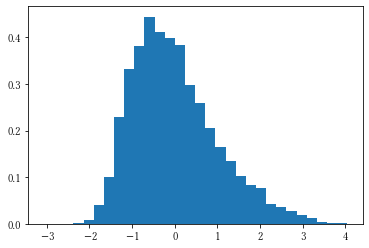

In [10]:
plt.hist(dataset_of_firm_size3, bins=30, density=True)

簿価時価比率

In [11]:
group_by_date = data.groupby(level=1)

dataset_of_bm = []
for date, value in group_by_date:
    book_to_market = value['自己資本（百万円）'] /value['時価総額（百万円）']
    
    #自己資本がマイナスである銘柄を除去
    book_to_market = book_to_market[book_to_market >0]
    
    book_to_market = correct_skewness(book_to_market)
    book_to_market = standardize_characteristics(book_to_market)
    book_to_market = trim_outliers(book_to_market)
    
    book_to_market.name = '簿価時価比率'
    
    dataset_of_bm.append(book_to_market)
    
dataset_of_bm = pd.concat(dataset_of_bm)
    

財務レバレッジ

In [12]:
group_by_date = data.groupby(level=1)

dataset_of_leverage1 = []
for date, value in group_by_date:
    financial_leverage = value['総資産（百万円）'] /value['時価総額（百万円）']
    financial_leverage = correct_skewness(financial_leverage)
    financial_leverage = standardize_characteristics(financial_leverage)
    financial_leverage = trim_outliers(financial_leverage)
    
    financial_leverage.name = '財務レバレッジ'
    
    dataset_of_leverage1.append(financial_leverage)
    


In [13]:
dataset_of_leverage = []
dataset_of_leverage = pd.concat(dataset_of_leverage1)

(array([0.06107931, 0.02882972, 0.04662027, 0.06543469, 0.07910893,
        0.10618195, 0.13664364, 0.17399702, 0.23171364, 0.27748154,
        0.34154933, 0.40998809, 0.49270918, 0.45863013, 0.47939356,
        0.45238291, 0.37361181, 0.2534074 , 0.14432013, 0.07832933,
        0.04298212, 0.02106488, 0.00847688, 0.01164207, 0.00828978,
        0.00512459, 0.01378338, 0.01499956, 0.03627753, 0.04227528]),
 array([-2.61664711, -2.41241245, -2.20817779, -2.00394314, -1.79970848,
        -1.59547382, -1.39123917, -1.18700451, -0.98276985, -0.77853519,
        -0.57430054, -0.37006588, -0.16583122,  0.03840343,  0.24263809,
         0.44687275,  0.6511074 ,  0.85534206,  1.05957672,  1.26381138,
         1.46804603,  1.67228069,  1.87651535,  2.08075   ,  2.28498466,
         2.48921932,  2.69345398,  2.89768863,  3.10192329,  3.30615795,
         3.5103926 ]),
 <BarContainer object of 30 artists>)

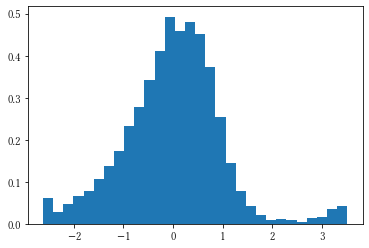

In [14]:
plt.hist(dataset_of_leverage, bins=30, density=True)

# 1/PER

In [15]:
group_by_date = data.groupby(level=1)

dataset_of_price_to_earnings = []
for date, value in group_by_date:
    earnings_over_market_equity = value[
        '当期利益（百万円）'
    ] / value['時価総額（百万円）']
    
    #自己資本がマイナスである銘柄を除去
    earnings_over_market_equity = earnings_over_market_equity[
        earnings_over_market_equity > 0
    ]
    
    earnings_over_market_equity = correct_skewness(
        earnings_over_market_equity
    )
    
    earnings_over_market_equity = standardize_characteristics(
        earnings_over_market_equity
    )
    
    earnings_over_market_equity = trim_outliers(
        earnings_over_market_equity
    )
    
    earnings_over_market_equity.name = 'E(+)/P'
    
    dataset_of_price_to_earnings.append(earnings_over_market_equity)
    
dataset_of_price_to_earnings = pd.concat(dataset_of_price_to_earnings)



(array([0.06107931, 0.02882972, 0.04662027, 0.06543469, 0.07910893,
        0.10618195, 0.13664364, 0.17399702, 0.23171364, 0.27748154,
        0.34154933, 0.40998809, 0.49270918, 0.45863013, 0.47939356,
        0.45238291, 0.37361181, 0.2534074 , 0.14432013, 0.07832933,
        0.04298212, 0.02106488, 0.00847688, 0.01164207, 0.00828978,
        0.00512459, 0.01378338, 0.01499956, 0.03627753, 0.04227528]),
 array([-2.61664711, -2.41241245, -2.20817779, -2.00394314, -1.79970848,
        -1.59547382, -1.39123917, -1.18700451, -0.98276985, -0.77853519,
        -0.57430054, -0.37006588, -0.16583122,  0.03840343,  0.24263809,
         0.44687275,  0.6511074 ,  0.85534206,  1.05957672,  1.26381138,
         1.46804603,  1.67228069,  1.87651535,  2.08075   ,  2.28498466,
         2.48921932,  2.69345398,  2.89768863,  3.10192329,  3.30615795,
         3.5103926 ]),
 <BarContainer object of 30 artists>)

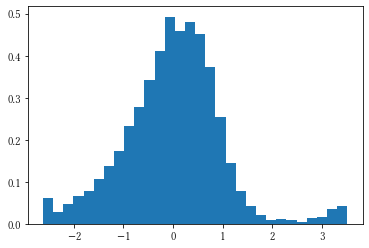

In [16]:
plt.hist(dataset_of_leverage, bins=30, density=True)

In [17]:
deficit_dummy = data['当期利益（百万円）'].apply(
    lambda x: np.nan if np.isnan(x) else 1 if x<= 0 else 0
)
deficit_dummy = deficit_dummy.rename('赤字ダミー')



In [18]:
period = 25 #移動平均の期間を25日にする

group_by_security = data.groupby('SC')  #銘柄ごとに計算

dataset_mv_returns = []
for security, value in group_by_security:
    equity_price = value['時価総額（百万円）']
    moving_average = equity_price.rolling(period).mean()
    moving_average = np.log(equity_price) - np.log(moving_average)
    moving_average.name = f'{period}日移動平均乖離率'
    dataset_mv_returns.append(moving_average)
    


In [19]:
dataset_mv_returns = pd.concat(dataset_mv_returns)

del period

In [20]:
dataset_mv_returns

SC    日時        
1301  2020-12-02         NaN
      2020-12-03         NaN
      2020-12-04         NaN
      2020-12-07         NaN
      2020-12-08         NaN
                      ...   
9997  2021-12-24   -0.030917
      2021-12-27   -0.035903
      2021-12-28   -0.015369
      2021-12-29    0.022555
      2021-12-30    0.015345
Name: 25日移動平均乖離率, Length: 960897, dtype: float64

In [21]:
#25日移動平均乖離率の対数変換、標準化、外れ値
group_by_data = dataset_mv_returns.groupby('日時')

dataset_mv_returns1 = []
for date, value in group_by_data:
    if value.isnull().all(): #グループ後のすべての行、カラムにについてnull判定
        continue
    processed_mv = standardize_characteristics(value)
    processed_mv = trim_outliers(processed_mv)
    processed_mv.name = value.name
    dataset_mv_returns1.append(processed_mv)
    

        

In [22]:
dataset_mv_returns = pd.concat(dataset_mv_returns1)

# マーケットベータ

In [23]:
#1つの銘柄、1つのウィンドウに対してregressionする関数

def calculate_beta_for_one_security_and_period(
    data: pd.DataFrame,
    endog_name,
    exog_names, model
):
    data = data.reset_index()
    security_code = data['SC'].unique()[0]
    end_date = data['日時'].max()
    
    endog = data[endog_name].values
    exog = data[exog_names].values
    
    model.fit(X=exog, y=endog) #線形回帰を行う
    
    #回帰係数を保存。coef_にベータが入っている。
    betas = np.append(model.intercept_,model.coef_)
    
    #求めたベータをDataFrameとして保存
    index = pd.MultiIndex.from_tuples(
        [(security_code, end_date)], names=['SC', ' 日時']
    )
    
    result = pd.DataFrame([betas],
                          columns=['alpha'] + list(exog_names),
                          index=index, dtype='float32')
    return result
    

In [24]:
# window幅125日でrolling regressionする
ROLLING_WINDOW = 125

def run_time_series_regression_on_one_security(
    data_one_security_time_series: pd.DataFrame,
    endog_name,
    exog_names, model
):
    # endog_name + exog_namesカラムがnanであるものを削除
    data_for_estimation = data_one_security_time_series.dropna(
        subset=endog_name + exog_names
    )
    length_data = data_for_estimation.shape[0]
    
    results = []
    #length_data < ROLLING_WINDOWならスキップされる
    for i in range(length_data - ROLLING_WINDOW):
        data = data_for_estimation.iloc[i:ROLLING_WINDOW + i]
        results.append(
            calculate_beta_for_one_security_and_period(
                data,
                endog_name,
                exog_names,
                model
            )
        )
        
    #サンプルサイズがwindow幅より少ないときはNoneを返す
    if not results:
        return None
    
    results = pd.concat(results)
    
    return results

In [25]:
#全銘柄に対してループさせる関数
def run_rolling_regression_over_all_securities(
    data_with_excess_returns,
    endog_name,
    exog_names=None
):
    #endog_name以外のカラムを抽出
    exog_names = exog_names or data_with_excess_returns.columns[
        ~data_with_excess_returns.column.isin(endog_name)
    ]
    
    #これをmodelとして使用する
    model = linear_model.LinearRegression()
    
    group_by_security = data_with_excess_returns.groupby('SC')
    
    results = []
    for security, values in tqdm(group_by_security):
        
        result = run_time_series_regression_on_one_security(
            values,
            endog_name,
            exog_names,
            model
        )
        if result is None:
            continue
        results.append(result)
        
    results = pd.concat(results)
    return results

In [26]:
market_betas = run_rolling_regression_over_all_securities(
    data,
    endog_name=['超過収益率'],
    exog_names=['市場超過収益率']
)

#「市場超過収益率」に対する回帰係数　-> マーケットベータなので名前を変更
market_betas.rename(
    columns={'市場超過収益率':'market_beta'},
    inplace=True
)    


C:/Users/masa/AppData/Local/Temp/xpython_18068/1346331448.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for security, values in tqdm(group_by_security):


  0%|          | 0/3750 [00:00<?, ?it/s]

In [27]:
#業種名も分析用のデータに追加する
industry = data['業種']

In [28]:
#計算した変数を1つのDataFrameにまとめる
data_for_analysis = pd.concat([
    data[['超過収益率', '市場超過収益率', '収益率', '市場収益率']],
    market_betas,
    dataset_of_firm_size,
    dataset_of_bm,
    dataset_of_leverage,
    dataset_of_price_to_earnings,
    deficit_dummy,
    dataset_mv_returns,
    industry

], axis=1)

In [60]:
market_betas.index.values

array([(1301, Timestamp('2021-06-07 00:00:00')),
       (1301, Timestamp('2021-06-08 00:00:00')),
       (1301, Timestamp('2021-06-09 00:00:00')), ...,
       (9997, Timestamp('2021-11-25 00:00:00')),
       (9997, Timestamp('2021-11-26 00:00:00')),
       (9997, Timestamp('2021-11-29 00:00:00'))], dtype=object)

In [59]:
industry.index.values

array([(1301, Timestamp('2020-12-02 00:00:00')),
       (1301, Timestamp('2020-12-03 00:00:00')),
       (1301, Timestamp('2020-12-04 00:00:00')), ...,
       (9997, Timestamp('2021-12-28 00:00:00')),
       (9997, Timestamp('2021-12-29 00:00:00')),
       (9997, Timestamp('2021-12-30 00:00:00'))], dtype=object)

In [46]:
data_for_analysis

超過収益率   市場超過収益率       収益率     市場収益率  alpha  market_beta  \
SC                                                                            
1301 2020-12-02  0.008601  0.002710  0.008602  0.002711    NaN          NaN   
     2020-12-03 -0.001401  0.000758 -0.001400  0.000759    NaN          NaN   
     2020-12-04  0.001401  0.000359  0.001402  0.000360    NaN          NaN   
     2020-12-07 -0.000001 -0.008735  0.000000 -0.008734    NaN          NaN   
     2020-12-08  0.001790  0.000043  0.001790  0.000044    NaN          NaN   
...                   ...       ...       ...       ...    ...          ...   
9997 2021-12-24       NaN       NaN  0.005926 -0.001095    NaN          NaN   
     2021-12-27       NaN       NaN -0.007360 -0.004784    NaN          NaN   
     2021-12-28       NaN       NaN  0.019285  0.013541    NaN          NaN   
     2021-12-29       NaN       NaN  0.039307 -0.002261    NaN          NaN   
     2021-12-30       NaN       NaN -0.007014 -0.003023    NaN          NaN   

                     企業規模    簿価時価比率   財務レバレッジ    E(+)/P  赤字ダミー  25日移動平均乖離率  \
SC                                                                           
1301 2020-12-02  0.098030  0.369924  0.647414  0.312352    0.0         NaN   
     2020-12-03  0.096409  0.373596  0.651694  0.317188    0.0         NaN   
     2020-12-04  0.097158  0.374147  0.652051  0.314111    0.0         NaN   
     2020-12-07  0.103191  0.362466  0.642891  0.299969    0.0         NaN   
     2020-12-08  0.103886  0.365409  0.645096  0.305088    0.0         NaN   
...                   ...       ...       ...       ...    ...         ...   
9997 2021-12-24  0.538881  0.843322  0.677204  1.268356    0.0   -0.298980   
     2021-12-27  0.540579  0.845455  0.677012  1.269918    0.0   -0.267877   
     2021-12-28  0.545413  0.833718  0.666410  1.257576    0.0   -0.106873   
     2021-12-29  0.562669  0.806818  0.645058  1.230335    0.0    0.332719   
     2021-12-30  0.559728  0.815293  0.651737  1.240066    0.0    0.175696   

                    業種       PER  
SC                                
1301 2020-12-02  水産・農林  0.312352  
     2020-12-03  水産・農林  0.317188  
     2020-12-04  水産・農林  0.314111  
     2020-12-07  水産・農林  0.299969  
     2020-12-08  水産・農林  0.305088  
...                ...       ...  
9997 2021-12-24     小売  1.268356  
     2021-12-27     小売  1.269918  
     2021-12-28     小売  1.257576  
     2021-12-29     小売  1.230335  
     2021-12-30     小売  1.240066  

[960897 rows x 14 columns]

In [54]:
data_for_analysis_tes = pd.concat([
    data[['超過収益率', '市場超過収益率', '収益率', '市場収益率']],
    #market_betas
    dataset_of_firm_size,
    #dataset_of_bm,
    #dataset_of_leverage,
    #dataset_of_price_to_earnings,
    #deficit_dummy,
    #dataset_mv_returns,
    #industry

], axis=1)
data_for_analysis_tes

超過収益率   市場超過収益率       収益率     市場収益率      企業規模
SC   日時                                                          
1301 2020-12-02  0.008601  0.002710  0.008602  0.002711  0.098030
     2020-12-03 -0.001401  0.000758 -0.001400  0.000759  0.096409
     2020-12-04  0.001401  0.000359  0.001402  0.000360  0.097158
     2020-12-07 -0.000001 -0.008735  0.000000 -0.008734  0.103191
     2020-12-08  0.001790  0.000043  0.001790  0.000044  0.103886
...                   ...       ...       ...       ...       ...
9997 2021-12-24       NaN       NaN  0.005926 -0.001095  0.538881
     2021-12-27       NaN       NaN -0.007360 -0.004784  0.540579
     2021-12-28       NaN       NaN  0.019285  0.013541  0.545413
     2021-12-29       NaN       NaN  0.039307 -0.002261  0.562669
     2021-12-30       NaN       NaN -0.007014 -0.003023  0.559728

[960897 rows x 5 columns]

In [50]:
industry

SC    日時        
1301  2020-12-02    水産・農林
      2020-12-03    水産・農林
      2020-12-04    水産・農林
      2020-12-07    水産・農林
      2020-12-08    水産・農林
                    ...  
9997  2021-12-24       小売
      2021-12-27       小売
      2021-12-28       小売
      2021-12-29       小売
      2021-12-30       小売
Name: 業種, Length: 960897, dtype: object

In [30]:
data_for_analysis.head()

超過収益率   市場超過収益率       収益率     市場収益率  alpha  market_beta  \
SC                                                                            
1301 2020-12-02  0.008601  0.002710  0.008602  0.002711    NaN          NaN   
     2020-12-03 -0.001401  0.000758 -0.001400  0.000759    NaN          NaN   
     2020-12-04  0.001401  0.000359  0.001402  0.000360    NaN          NaN   
     2020-12-07 -0.000001 -0.008735  0.000000 -0.008734    NaN          NaN   
     2020-12-08  0.001790  0.000043  0.001790  0.000044    NaN          NaN   

                     企業規模    簿価時価比率   財務レバレッジ    E(+)/P  赤字ダミー  25日移動平均乖離率  \
SC                                                                           
1301 2020-12-02  0.098030  0.369924  0.647414  0.312352    0.0         NaN   
     2020-12-03  0.096409  0.373596  0.651694  0.317188    0.0         NaN   
     2020-12-04  0.097158  0.374147  0.652051  0.314111    0.0         NaN   
     2020-12-07  0.103191  0.362466  0.642891  0.299969    0.0         NaN   
     2020-12-08  0.103886  0.365409  0.645096  0.305088    0.0         NaN   

                    業種  
SC                      
1301 2020-12-02  水産・農林  
     2020-12-03  水産・農林  
     2020-12-04  水産・農林  
     2020-12-07  水産・農林  
     2020-12-08  水産・農林

In [31]:
#赤字ダミーが1となっている銘柄のE/P ratioをゼロにして赤字ダミーを有効化する
data_for_analysis = data_for_analysis.assign(
    PER=lambda x: np.where(
        data_for_analysis['赤字ダミー'] == 1,
        0,
        data_for_analysis['E(+)/P']
    )
)

In [32]:
#変数を一度保存する
data_for_analysis.to_pickle(f'{DATA_DIR}data_for_analysis_fin.pickle')

In [44]:
data_for_analysis.to_csv(f'{DATA_DIR}data_for_analysis_fin.csv')

#　株価データを使った線形回帰モデルの作成
銘柄の特徴によって日時リターンのばらつきを説明できるか検証する
→定義してきた説明変数が翌日上がりやすいか下がりやすいか調べる

最小二乗法でデータに最も成語的な回帰係数を計算し線形回帰モデルを作成

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'Yu Mincho'
from IPython.core.display import display
%matplotlib inline

#データの保存場所を指定
#この場合は、C:/sample/linear_regression/を読み書きする
WORK_DIR = 'D:\DEV\workspace\stock_trade\linear_regression'
DATA_DIR = 'D:\DEV\workspace\stock_trade\linear_regression\data'

#2.2.1で作ったデータを読み込む
data_for_analysis_loaded = pd.read_pickle(
    f'{DATA_DIR}data_for_analysis_fin.pickle'
)

In [ ]:
data_for_analysis_loaded

In [ ]:
independent_variables_names = [
    'market_beta', '企業規模', '簿価時価比率', '財務レバレッジ',
    '赤字ダミー', '25日移動平均乖離率', 'PER'
]
columns_to_use = [
    '業種', '翌日収益率', '翌日超過収益率', '収益率', '市場収益率'
] + independent_variables_names

data_for_analysis = data_for_analysis_loaded.assign(
    #超過収益率を1日分ずらして、Y_iを作成
    翌日超過収益率=lambda x: x['超過収益率'].groupby(level=0).shift(-1),
    #後のシミュレーションで利用するので一緒に作成しておく
    翌日収益率=lambda x:x['収益率'].groupby(level=0).shift(-1)
    
)[columns_to_use]

In [ ]:
#証券コードごとに5つずつ表示して、計算結果を確認
data_for_analysis.dropna(
    subset=independent_variables_names
).groupby(level=0).head()

日本市場において金融業の財務データの意味が大きく異なるため分析対象外とする

In [ ]:
exclude_fin = data_for_analysis[
    data_for_analysis['業種'].apply(
        lambda x: x not in['銀行', '証券・先物', '保険', 'その他金融']
    )
]

In [ ]:
exclude_fin.xs(9997,level=0)

In [ ]:
#2021年7月6日のデータを取得
data_tmp = exclude_fin.dropna(
    subset=independent_variables_names
).xs(pd.datetime(2021,7,6),level=1)
exog = sm.add_constant(data_tmp[independent_variables_names])
endog = data_tmp['翌日超過収益率']
sm.OLS(endog, exog).fit().summary()

In [ ]:
#2017年7月6日のデータを取得
''''
data_tmp = exclude_fin.dropna(
    subset=independent_variables_names
).xs(pd.datetime(2016,7,6),level=1)
exog = sm.add_constant(data_tmp[independent_variables_names])
endog = data_tmp['翌日超過収益率']
sm.OLS(endog, exog).fit().summary()
'''

In [ ]:
#クロスセクション会にのループ
def cross_sectional_regression_overtime(
    data_with_excess_returns,
    endog_name, exog_names
):
    group_by_date = data_with_excess_returns.groupby('日時')
    
    results = []
    for date_point, values in tqdm(group_by_date):
        
        result = cross_sectional_regression(
            values,
            endog_name,
            exog_names
        )
        if result is None:
            continue
        results.append(result)
        
    results = pd.concat(results)
    return results

In [ ]:
#クロスセクション回帰を行う関数
def cross_sectional_regression(data, endog_name, exog_names):
    data = data.reset_index()
    data = data.dropna(subset=endog_name + exog_names)
    
    if data.shape[0] < 1: #空のDataFrameは無視する
        return None
    
    end_date = data[endog_name]
    
    endog = data[endog_name]
    
    exog = data[exog_names]
    exog = exog.assign(constant=1)
    
    #最小二乗法
    model = sm.OLS(endog, exog)
    
    result = model.fit()
    betas = results.params.rename(end_date)
    
    result = pd.DataFrame(betas).T
    
    return result

In [ ]:
#回帰係数の平均値をとる
def caluculate_mean_value_of_coefficients(cofficients):
    mean = coeffients.mean().rename('mean')
    std_err = (
        coefficients.std() / np.sqrt(coefficients.shape[0])
    ).rename('std err')
    t_stat = pd.concat([mean, std_err, t_stat],axis=1)

    return result
                

In [ ]:
coefficients_excluding_fin = cross_sectional_regression_overtime(
    exclude_fin, endog_name=['翌日超過収益率'],
    exog_names=independent_variables_names
)

#結果を出力して確認
display(coefficients_excluding_fin.head())

In [ ]:
result = calculate_mean_value_of_coefficients(
    coeffients_excluding_fin
)

#結果を出力して確認
display(result)

有意水準95%の範囲を確認

In [ ]:
window_size = 50
rolling_coefficients = coefficients_excluding_fin.rolling(
    window_size
).mean()

rolling_std_err = (
    coefficients_excluding_fin.rolling(window_size).std()
    / np.sqrt(window_size)
)

rolling_coefficients.index.rename('日付', inplace=True)

fig, axes=plt.subplots(4, 2, figsize=(12,12))

for col, ax in zip(rolling_coefficients.columns, axes.flatten()):
    sns.lineplot(data=rolling_coefficients[col], ax=ax)
    sns.lineplot(
        data=rolling_coefficients[col] + 2*rollling_std_err[col],
        ax=ax,
        style='-',
        color='k',
        linewidth=1,
        alpha=.5
    )
    sns.lineplot(
        data=rolling_coefficients[col] - 2*rolling_std_err[col],
        ax=ax,
        style='-',
        color='k',
        linerwidth=1,
        alpha=.5
    )
    ax.hlines(  #y=0の破線を引く
        0, *ax.get_xlim(),
        linerstyles=':',alpha=.5
    )
    ax.set_title(col)
fig.tight_layout() #グラフ同士の間隔を広げる

25日移動平均乖離率が上位、下位２０％も属する銘柄を保有するポートフォーリオ

In [35]:
def create_portfolio_by_one_variable(
    data,
    sort_by,
    q,
    labels=None,
    group_name=None
):
    group_by_data = data.groupby('日時')
    
    if isinstance(q. int) and labels is None:
        labels = range(q)
    values = []
    for date, value in group_by_date:
        if value[sort_by].isnull().all(): #空のDataFrameは無視する
            continue
        
        value = value.assign(
            quantile=lambda x: pd.qcut(
                x[sort_by], q, labels=labels
            )
        )
        
        if group_name is not None:
            value.rename(columns={'quantile':group_name}, inplace=True)
            
        values.appned(value)
    return pd.concat(values)
